A Hierarchical Bayesian Model of the Bundes League
================================


$$\\[2pt]$$


Igor Marfin **[Unister Gmb@2014]** < <igor.marfin@unister.de>>


$$\\[40pt]$$


Abstract
----------------



--------------------------

I came across the following blog post on [[1]](#Blog): I quote from it, about the realization for Premier League Football:

>It occurred to me that this problem is perfect for a Bayesian model.
We want to infer the latent paremeters (every team's strength) that are generating the data we observe (the scorelines). Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.


In this tutorial, I'm going to reproduce the  model described in this post  [[1]](#Blog) using pymc. While they used the results of the 2013-2014 Premier League, I'm going to utilize the results of the 2013-2014 Bundes League.

More details can be found at my repository https://bitbucket.org/iggy_floyd/bayesian-pymc-bundesliga.


$$\\[5pt]$$
Outline
------------------


------------------


* Abstract
* Initialization of the notebook
* Getting and cleaning the data
  * Scraping data from the Wikipedia
  * Final preparation of the dataframe
* The model
* Visualization
  * Plot of the Mean of Posteriors
  * Plot of the HPDI
* Simulations
* Prediction of 2014/2015 BundesLiga final results (total scored goals)
* Prediction of the matches scoring in 2013/2014 season
* Prediction of the matches scoring for 2015/2016 season

$$\\[5pt]$$
Initialization 
--------------------------

________

To set up the python environment for the data analysis and make a nicer style of the notebook, one can run the following commands in the beginning of our modeling:


In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline
ion()

import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats





# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from book_format import load_style, figsize, set_figsize
load_style()



Populating the interactive namespace from numpy and matplotlib


$$\\[5pt]$$
Getting and cleaning the data
-------------


--------------------------


Well, the most obvious way to find data is to address ourselves to pages of the 
Wikipedia. After googling, we have come to the page [[2]](#Results)  with results of 
the 2013/14 Bundesliga. They contain scores of the 51st season of the Bundesliga, Germany's premier football league. The season began on 9 August 2013 and the final matchday was on 10 May 2014.


$$\\[5pt]$$
### Scraping data from the Wikipedia



I have found myself a challenge to work with data presented in the Wikipedia. 
Basicaly, we need some universal tool to scrape the data from a table placed on a Wikipedia page. Below, one can find the useful code to scrapping data from the wiki.
I have extended the approach given in the post [[3]](#Scrapper).



In [2]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    A tool to scrape data from wiki-pages
'''
from bs4 import BeautifulSoup
import urllib2
import warnings
from  StringIO import StringIO
import pandas as pd
warnings.filterwarnings('ignore')


class MyWikiParser(BeautifulSoup):
    ''' BeautifulSoup parser: parses <table> </table> tags'''
    
    def __init__(self,page,table_class_properties,table_header):
        BeautifulSoup.__init__(self,page,fromEncoding="UTF-8")
        self.recording = 0
        self.data = []
        self.table_class_properties = table_class_properties
        self.table_header = table_header

    def handle_data(self,column_tag="td"):
        tables = self.findAll("table", self.table_class_properties)         
        for table in tables:    
            first_row=table.find("tr")    
            first_cell_in_first_row = first_row.find(column_tag)
            rows = []
            if (first_cell_in_first_row is not None) and (self.table_header in str(first_cell_in_first_row)):        
                for row in table.findAll("tr"):            
                    vals=row.find_all('td')
                    vals=map(lambda x: x.text.encode('utf-8').split('!')[1] if len( x.text.encode('utf-8').split('!'))>1 else x.text.encode('utf-8').split('!')[0], vals) # fix some text data            
#                    rows.append([val.text.encode('utf-8').replace('\xe2\x95\xb2','/').replace('\xe2\x80\x93','-') for val in vals])
                    rows.append([val.replace('\xe2\x95\xb2','/').replace('\xe2\x80\x93','-') for val in vals])
                self.data=rows

        
class Wiki_Table(object):
    ''' exctracts values for the table from Wiki-Page files '''
 
    def __init__(self,url,table_class_properties,table_header,column_tag="td"):
        self.table = []
        header = {'User-Agent': 'Mozilla/5.0'} #Needed to prevent 403 error on Wikipedia        
        req = urllib2.Request(url,headers=header)
        page = urllib2.urlopen(req)       
        parser=MyWikiParser(page,table_class_properties,table_header)
        parser.handle_data(column_tag)   
        self.table = parser.data
        


# a page containing the data
wikipage='https://en.wikipedia.org/wiki/2013%E2%80%9314_Bundesliga#Results'

# a pattern on the header to find the table among others
title_pattern='Home ╲ Away'

# a pattern on the class properties of the table used to find it 
table_props={"class" : "wikitable"}

# parse the table from the wiki page
wt=Wiki_Table(wikipage,table_props,title_pattern)

# create a dataframe on the data
table_csv=map(lambda x: ','.join(x),wt.table)
table_csv='\n'.join(table_csv)
data = StringIO(table_csv)

#df = pd.read_csv(data,delimiter=',')
df = pd.read_csv(data,delimiter=',',index_col=0)

print df


                          AUG  LEV  FCB  DOR  MGL  BRS  FRA  FRE  HAM  H96  \
Home / Away                                                                  
FC Augsburg               NaN  1-3  1-0  0-4  2-2  4-1  2-1  2-1  3-1  1-1   
Bayer Leverkusen          2-1  NaN  1-1  2-2  4-2  1-1  0-1  3-1  5-3  2-0   
Bayern Munich             3-0  2-1  NaN  0-3  3-1  2-0  5-0  4-0  3-1  2-0   
Borussia Dortmund         2-2  0-1  0-3  NaN  1-2  2-1  4-0  5-0  6-2  1-0   
Borussia Mönchengladbach  1-2  0-1  0-2  2-0  NaN  4-1  4-1  1-0  3-1  3-0   
Eintracht Braunschweig    0-1  1-0  0-2  1-2  1-1  NaN  0-2  0-1  4-2  3-0   
Eintracht Frankfurt       1-1  0-2  0-1  1-2  1-0  3-0  NaN  1-4  2-2  2-3   
SC Freiburg               2-4  3-2  1-1  0-1  4-2  2-0  1-1  NaN  0-3  2-1   
Hamburger SV              0-1  2-1  1-4  3-0  0-2  4-0  1-1  1-1  NaN  3-1   
Hannover 96               2-1  1-1  0-4  0-3  3-1  0-0  2-0  3-2  2-1  NaN   
Hertha BSC                0-0  0-1  1-3  0-4  1-0  2-0  6-1  0-0

In [3]:
# store the code to the file
%history -f Wiki_Table.py -l 1

File u'Wiki_Table.py' exists. Overwrite? y
Overwriting file.


$$\\[5pt]$$

### Final preparation of the dataframe

Clearly, we need do some cleaning here. Let's split the score into two numeric columns.


In [4]:
df.index = df.columns
rows = []
for i in df.index:
    for c in df.columns:
        if i == c: continue
        score = df.ix[i, c]
        score = [int(row) for row in score.split('-')]        
        rows.append([i, c, score[0], score[1]])
df_update = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score'])
df_update.head()



,home,away,home_score,away_score
0,AUG,LEV,1,3
1,AUG,FCB,1,0
2,AUG,DOR,0,4
3,AUG,MGL,2,2
4,AUG,BRS,4,1


Much better, but still not done. We need an easy way to refer to the teams. Let's create a lookup table, which maps team name to a unique integer i.

In [5]:
teams = df_update.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
print "Number of teams: {0}".format(len(teams))
teams.head()

Number of teams: 18


,team,i
0,AUG,0
1,LEV,1
2,FCB,2
3,DOR,3
4,MGL,4


Now, we can merge this into our main dataframe to create the columns i_home and i_away.

In [6]:
df = pd.merge(df_update, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home,away,home_score,away_score,i_home,i_away
0,AUG,LEV,1,3,0,1
1,AUG,FCB,1,0,0,2
2,AUG,DOR,0,4,0,3
3,AUG,MGL,2,2,0,4
4,AUG,BRS,4,1,0,5


Now, let's extract the data into arrays, so that pymc can work with it. Note that each of the arrays `(observed_home_goals, observed_away_goals, home_team, away_team)` are the same length, and that the ith entry of each refers to the same game.

In [7]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

print "Number of games: {0}".format(num_games)

Number of games: 306


This next step is unnecessary, but it would be nice to do it  - come up with some decent starting values for the att and def parameters. The log transformation will make sense shortly.

In [8]:
g = df.groupby(['i_away'])
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean()) # negative because this property plays
# a negative role



$$\\[5pt]$$
The model
-------------

------------


In the post [[1]](#Blog), they model the observed goals-scored counts as follows.


The Bundes league is made up by a total of T= 18 teams, playing each other once 
in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season (306 games) as $y_{g1}$ and $y_{g2}$ respectively. 

The vector of observed counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:

$$y_{gi}| \theta_{gj} \sim\;\;  Poisson(\theta_{gj}),$$

where the  $\theta_{gj}$ parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.

We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:

$$log \theta_{g1} = home + att_{h(g)} + def_{a(g)} $$
$$log \theta_{g2} = att_{a(g)} + def_{h(g)}$$

the parameter `home` represents the advantage for the team hosting the game
and we assume that this effect is constant for all the teams and
throughout the season. Here `h(g)` and `a(g)` denote the `home` and  `away` teams in the g-th game.

Note that we are breaking out team strength into attacking and defending strength. A large negative defense parameter will sap the mojo from the opposing team's attacking parameter.

The variable $home$ is modelled as a fixed effect, assuming a standard 
flat prior distribution. We use the notation of describing the Normal distribution in terms of mean and the precision. 

$$home \sim\; Normal(0,0.0001).$$


Conversely, for each t = 1, ..., 18, the team-specific effects are modelled as exchangeable from a common distribution:

$$att_t \sim\; Normal(\mu_{att}, \tau_{att})$$

and 

$$def_t \sim\; Normal(\mu_{def}, \tau_{def}).$$


To ensure identifiability, we also impose a sum-to-zero constraint on the attack and defense parameters:

$$\sum_t^T att_t =0$$

$$\sum_t^T def_t =0$$


We could simplify our model. It didn't make sense to me to have a $\mu_{att}$ when we're enforcing the sum-to-zero constraint by subtracting the mean anyway. So I eliminated $\mu_{att}$ and $\mu_{def}$:

$$att_t \sim\; Normal(0, \tau_{att})$$

and 

$$def_t \sim\; Normal(0, \tau_{def}).$$

Also because of the sum-to-zero constraint, it seemed to me that we needed an intercept term in the log-linear model, capturing the average goals scored per game by the away team. This we model with the  `intercept`:

$$log \theta_{g1} = intercept+home + att_{h(g)} + def_{a(g)} $$
$$log \theta_{g2} = intercept+att_{a(g)} + def_{h(g)},$$

where `intercept` has a flat distribution

$$intercept \sim\; Normal(0,0.0001).$$

Below is what the model looks like in the PyMC. 

In [9]:
#defines the class for the Modeling
class Model(object):
    """ A Model class 
         :param np.ndarray data: The  data to use for learning the model.
         
    """

    def predict_match_map(self, data):
        raise NotImplementedError(
            'prediction not implemented for the class')

    def split_title(self,title):
        """Change "BaselineMethod" to "Baseline Method"."""
        words = []
        tmp = [title[0]]
        for c in title[1:]:
            if c.isupper():
                words.append(''.join(tmp))
                tmp = [c]
            else:
                tmp.append(c)
        words.append(''.join(tmp))
        return ' '.join(words)

    def find_map(self):
        ''' calculates the MAP '''
        raise NotImplementedError(
            'find_map not implemented yet')

    def load_map(self):
        ''' loads the calculated MAP '''
        raise NotImplementedError(
            'load_map not implemented yet')

    def draw_samples(self):
        ''' makes simulations '''
        raise NotImplementedError(
            'draw_samples not implemented yet')    
        
    def __str__(self):
        ''' string presentation of the class '''
        return self.split_title(self.__class__.__name__)


    def __init__(self, data):        
    
        logging.info('building the  model....') 

        #observed points in each game
        self.observed_home_goals = data['observed_home_goals']
        self.observed_away_goals = data['observed_away_goals']
    
        #hyperpriors in the model

        # parameter common to all teams
        # the 'home' parameter
        self.home = pm.Normal('home', 0, .0001, value=0)
        self.num_teams = data['num_teams']    
        self.home_team = data['home_team']
        self.away_team = data['away_team']        

        # 'precision' parameters in the team-specific 'att' or 'def' srength
        # it doesn't matter if we use  Uniform  or Gamma priors
        self.tau_att = pm.Gamma('tau_att', .1, .1, value=10)
        self.tau_def = pm.Gamma('tau_def', .1, .1, value=10)

        # the 'intercept' parameter to get the average of goals scored per game
        self.intercept = pm.Normal('intercept', 0, .0001, value=0)

        #team-specific parameters    
        self.team_atts = pm.Normal("team_atts", 
                        mu=0, 
                        tau=self.tau_att, 
                        size=self.num_teams, 
                        value=att_starting_points.values)
        
        self.team_defs = pm.Normal("team_defs", 
                        mu=0, 
                        tau=self.tau_def, 
                        size=self.num_teams, 
                        value=def_starting_points.values) 


        # trick to code the sum to zero contraint
        @pm.deterministic
        def atts(team_atts=self.team_atts):
            atts = team_atts.copy()
            atts = atts - np.mean(team_atts)
            return atts

        @pm.deterministic
        def defs(team_defs=self.team_defs):
            defs = team_defs.copy()
            defs = defs - np.mean(team_defs)
            return defs

        # the hiearchical parameters: parameter 'theta_home'
        @pm.deterministic
        def home_theta(home_team=self.home_team, 
            away_team=self.away_team, 
            home=self.home, 
            atts=atts, 
            defs=defs, 
            intercept=self.intercept): 
            return np.exp(intercept + 
                   home + 
                   atts[home_team] + 
                   defs[away_team])
        
        # parameter 'theta_away'    
        @pm.deterministic
        def away_theta(home_team=self.home_team, 
            away_team=self.away_team, 
            home=self.home, 
            atts=atts, 
            defs=defs, 
            intercept=self.intercept): 
            return np.exp(intercept + 
                atts[away_team] + 
                defs[home_team])   
    
        

        # what we want to predict in the model is points
        self.home_points = pm.Poisson('home_points', 
                          mu=home_theta, 
                          value=self.observed_home_goals, 
                          observed=True)
    
        self.away_points = pm.Poisson('away_points', 
                          mu=away_theta, 
                          value=self.observed_away_goals, 
                          observed=True)
        
        # our model collects all definitions in self.model
        self.model = pm.Model([self.home, self.intercept, self.tau_att, self.tau_def, 
                  home_theta, away_theta, 
                  self.team_atts, self.team_defs, atts, defs, 
                  self.home_points, self.away_points])
    
        logging.info('done building the  model') 
    

    
# create the model object used in the further analysis
observed_data_model = {
                'observed_home_goals':observed_home_goals,
                'observed_away_goals':observed_away_goals,
                'num_teams':num_teams,
                'home_team':home_team,
                'away_team':away_team,
            }
bundesliga_model = Model(observed_data_model)
? bundesliga_model    

INFO:root:building the  model....
INFO:root:done building the  model


Here we like to add all functionality of the basic Model:

* MAP calculation
* samples drawing 
* simulation of the season in the bundesliga.

We start with the MAP stuff.

In [11]:
'''
    a MAP support in the Model Class
'''
import os
import scipy as sp
import time

try:
    import ujson as json
except ImportError:
    import json

# First, we define functions to save/load our parameters to/from the file.
def save_np_vars(vars, savedir):
    """ Save a dictionary of numpy variables to `savedir`. We assume
        the directory does not exist; an OSError will be raised if it does.
    """
    logging.info('writing numpy vars to directory: %s' % savedir)
    os.mkdir(savedir)
    shapes = {}
    for varname in vars:
        data = vars[varname]
        var_file = os.path.join(savedir, varname + '.txt')
        np.savetxt(var_file, data.reshape(-1, data.size))
        shapes[varname] = data.shape

        ## Store shape information for reloading.
        shape_file = os.path.join(savedir, 'shapes.json')
        with open(shape_file, 'w') as sfh:
            json.dump(shapes, sfh)

    return
            
# Define the function to upload our parameters from the file
def load_np_vars(savedir):
    """Load numpy variables saved with `save_np_vars`."""
    shape_file = os.path.join(savedir, 'shapes.json')
    with open(shape_file, 'r') as sfh:
        shapes = json.load(sfh)

    vars = {}
    for varname, shape in shapes.items():
        var_file = os.path.join(savedir, varname + '.txt')
        vars[varname] = np.loadtxt(var_file).reshape(shape)

    return vars            


# property 'map_dir'
def _map_dir(self):
    ''' return the dir name where we store the MAP'''
    self.basename_map = 'map' 
    return os.path.join('data', self.basename_map)


#  calculatiton the MAP
def _find_map(self):
    """Find mode of posterior using Powell optimization."""
    
    tstart = time.time()
    logging.info('finding PMF MAP using Powell optimization...')
    self._map = pm.MAP(self.model)
    self._map.fit()

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)
    
    #pymc2
    # This is going to take a good deal of time to find, so let's save it.
    savedir = os.path.join('data',  self.basename_map)
    map_to_save={}    
    for var in list(self._map.variables):
        print "var: ", var
        map_to_save.update({str(var):var.value})
        
    self._map =  map_to_save   
    save_np_vars(self._map, self.map_dir)
    
    logging.info('MAP was stored in %s folder'%savedir)
    return

# load a map 
def _load_map(self):   
    """load map from the directory"""    
    self._map = load_np_vars(self.map_dir)
    return


def _map(self):
    """ a MAP property"""
    try:
        return self._map
    except:
        if os.path.isdir(self.map_dir):
            self.load_map()
        else:
            self.find_map()
        return self._map        

# Update our class with the new MAP infrastructure.
Model.find_map = _find_map
Model.load_map = _load_map
Model.map_dir = property(_map_dir)
Model.map = property(_map)     


# test: print a MAP for some variable: 'tau_att'
logging.info('MAP of  %s is %2.4f'%('tau_att',bundesliga_model.map['tau_att']))  
#print 'saving...'
#save_np_vars(bundesliga_model.map,bundesliga_model.map_dir)

INFO:root:MAP of  tau_att is 14.6564


saving...


Now we would like to introduce the MCMC sampling.

In [12]:
'''
    a MCMC support in the Model Class
'''

# Draw MCMC samples.
def _trace_dir(self):
    ''' trace dir property'''
    
    self.basename_mcmc = 'mcmc' 
    return os.path.join('data', self.basename_mcmc)



# Sampler 
def _draw_samples(self, nsamples=1000):
    ''' draws out samples '''
    
    # First make sure the trace_dir does not already exist.
    if os.path.isdir(self.trace_dir):
        raise OSError(
            'trace directory %s already exists. Please move or delete.' % self.trace_dir)

    # pymc2
    logging.info('drawing %d samples' % (nsamples))
    self.mcmc =pm.MCMC(self.model,db='txt',dbname=self.trace_dir)    
    logging.info('backing up trace to directory: %s' % self.trace_dir)
    self.mcmc.sample(nsamples)
    self.traces={}
    
    for var in list(self.mcmc.stochastics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        )

        
    for var in list(self.mcmc.deterministics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        )
    

        
    self.mcmc.db.close()

    

def _load_trace(self):
    ''' loads traces of MCMC to the model '''
    
    
    self.mcmc = pm.MCMC(self.model,db=pm.database.txt.load(self.trace_dir))     
    self.traces={}
    for var in list(self.mcmc.stochastics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        ) 
    for var in list(self.mcmc.deterministics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        )
    
   

# Update our class with the sampling infrastructure.
Model.trace_dir = property(_trace_dir)
Model.draw_samples = _draw_samples
Model.load_trace = _load_trace     


# let's make samples
bundesliga_model.draw_samples(100000)

INFO:root:drawing 100000 samples
INFO:root:backing up trace to directory: data/mcmc


 [-----------------100%-----------------] 100000 of 100000 complete in 98.7 sec

$$\\[5pt]$$
#### Diagnostics

Let's see if/how the model converged. The home parameter looks good, and indicates that home field advantage amounts to goals per game at the intercept.

We can see that it converges just like the model for the Premier League in the other tutorial.

I wonder and this is left as a question if all field sports have models of this form that converge.

Plotting home
Plotting tau_att


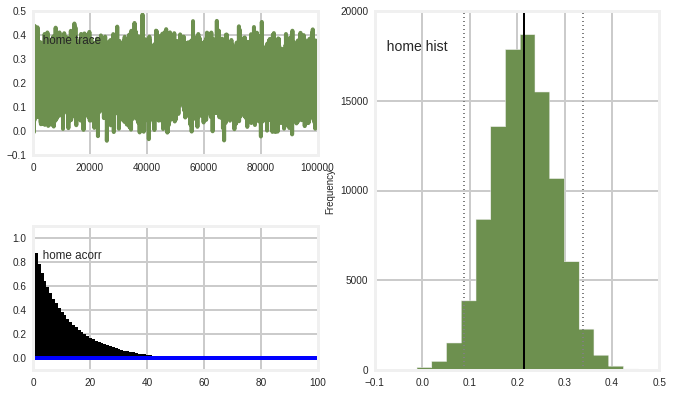

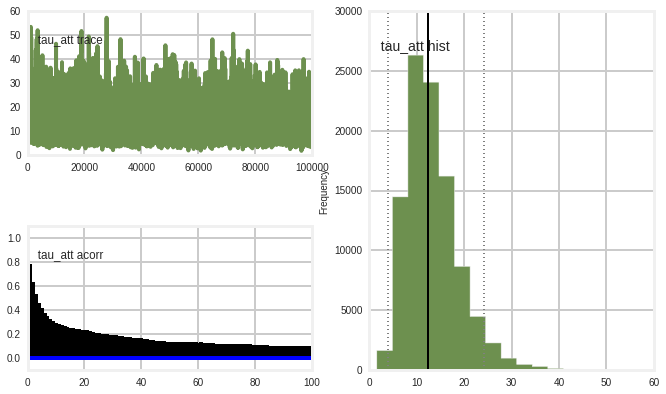

In [13]:
#  'home parameter'
pm.Matplot.plot(bundesliga_model.home)

#  'tau_att parameter for all commands'
pm.Matplot.plot(bundesliga_model.tau_att)

$$\\[5pt]$$
Visualization
-----------------

---------------------


We want to add additional functionality to our model:

    the plotter which will make plottings of teams' strength.


The strategy is the following:

>We will plot the additional information about team like Qualification or relegation taken from [[4]](#Table) together with distribution of the paramters `defs` and `atts`.

First, we scrappe data from the wiki.

In [14]:
# a page containing the data
wikipage='https://en.wikipedia.org/wiki/2013%E2%80%9314_Bundesliga#League_table'

# a pattern on the header to find the table among others
title_pattern='Pos'

# a pattern on the class properties of the table used to find it 
table_props={"class" : "wikitable"}

# parse the table from the wiki page
wt=Wiki_Table(wikipage,table_props,title_pattern,"th")

#print wt.table
# create a dataframe on the data
table_csv=map(lambda x: ','.join(x),wt.table)
table_csv='\n'.join(table_csv)
data = StringIO(table_csv)

df_final_table = pd.read_csv(data,delimiter=',',header=None)
df_final_table.columns = [
                'Pos', 'Team', 'Pld','W','D','L','GF','GA','GD','Pts','Qualification'
    ]
# fix some 'Qualification' values
df_final_table.loc[0:2,'Qualification'] = 'Champions_League_Group'
df_final_table.loc[3,'Qualification'] = 'Champions_PlayOff_Round'
df_final_table.loc[4,'Qualification'] = 'Europe_League_Group'
df_final_table.loc[5,'Qualification'] = 'Europe_League_PlayOff_Round'
df_final_table.loc[6,'Qualification'] = 'Europe_League_PlayOff_3rdRound'
df_final_table.loc[len(df_final_table)-3,'Qualification'] = 'Relegation_PlayOff'
df_final_table.loc[len(df_final_table)-2,'Qualification'] = 'Relegation_2ndBundesLiga'
df_final_table.loc[len(df_final_table)-1,'Qualification'] = 'Relegation_2ndBundesLiga'
print df_final_table.head(8)

   Pos                      Team  Pld   W  D   L  GF  GA   GD  Pts  \
0    1         Bayern Munich (C)   34  29  3   2  94  23  +71   90   
1    2         Borussia Dortmund   34  22  5   7  80  38  +42   71   
2    3                Schalke 04   34  19  7   8  63  43  +20   64   
3    4          Bayer Leverkusen   34  19  4  11  60  41  +19   61   
4    5             VfL Wolfsburg   34  18  6  10  63  50  +13   60   
5    6  Borussia Mönchengladbach   34  16  7  11  59  43  +16   55   
6    7                  Mainz 05   34  16  5  13  52  54   −2   53   
7    8               FC Augsburg   34  15  7  12  47  47    0   52   

                    Qualification  
0          Champions_League_Group  
1          Champions_League_Group  
2          Champions_League_Group  
3         Champions_PlayOff_Round  
4             Europe_League_Group  
5     Europe_League_PlayOff_Round  
6  Europe_League_PlayOff_3rdRound  
7                             NaN  


In [15]:
print df_final_table.tail(3)

    Pos                        Team  Pld  W   D   L  GF  GA   GD  Pts  \
15   16            Hamburger SV (O)   34  7   6  21  51  75  −24   27   
16   17          1. FC Nürnberg (R)   34  5  11  18  37  70  −33   26   
17   18  Eintracht Braunschweig (R)   34  6   7  21  29  60  −31   25   

               Qualification  
15        Relegation_PlayOff  
16  Relegation_2ndBundesLiga  
17  Relegation_2ndBundesLiga  


In order to plot the add. info, we need to add abbreviations of the teams.

In [16]:
# add abbvreviations
df_final_table['Abbvr'] = pd.Series(np.random.randn(), index=df_final_table.index)
def find_team(name):
    return np.array([ name in val for val in df_final_table['Team']])

# the whole list of teams in the 2013-2014 season of the BundesLiga
df_final_table.loc[find_team("Bayern Munich"),'Abbvr'] = "FCB" #1
df_final_table.loc[find_team("Borussia Dortmund"),'Abbvr'] = "DOR" #2
df_final_table.loc[find_team("Schalke 04"),'Abbvr'] = "S04" #3
df_final_table.loc[find_team("Bayer Leverkusen"),'Abbvr'] = "LEV" #4
df_final_table.loc[find_team("VfL Wolfsburg"),'Abbvr'] = "WOL" #5
df_final_table.loc[find_team("nchengladbach"),'Abbvr'] = "MGL" #6
df_final_table.loc[find_team("Mainz 05"),'Abbvr'] = "MAI" #7
df_final_table.loc[find_team("FC Augsburg"),'Abbvr'] = "AUG" #8
df_final_table.loc[find_team("1899 Hoffenheim"),'Abbvr'] = "HOF" #9
df_final_table.loc[find_team("Hannover 96"),'Abbvr'] = "H96" #10
df_final_table.loc[find_team("Hertha BSC"),'Abbvr'] = "BSC" #11
df_final_table.loc[find_team("Werder Bremen"),'Abbvr'] = "BRE" #12
df_final_table.loc[find_team("Eintracht Frankfurt"),'Abbvr'] = "FRA" #13
df_final_table.loc[find_team("SC Freiburg"),'Abbvr'] = "FRE" #14
df_final_table.loc[find_team("VfB Stuttgart"),'Abbvr'] = "STU" #15
df_final_table.loc[find_team("Hamburger SV"),'Abbvr'] = "HAM" #16
df_final_table.loc[find_team("rnberg"),'Abbvr'] = "NUR" #17
df_final_table.loc[find_team("Eintracht Braunschweig"),'Abbvr'] = "BRS" #18

print df_final_table.head(10)
print df_final_table.tail(3)



   Pos                      Team  Pld   W   D   L  GF  GA   GD  Pts  \
0    1         Bayern Munich (C)   34  29   3   2  94  23  +71   90   
1    2         Borussia Dortmund   34  22   5   7  80  38  +42   71   
2    3                Schalke 04   34  19   7   8  63  43  +20   64   
3    4          Bayer Leverkusen   34  19   4  11  60  41  +19   61   
4    5             VfL Wolfsburg   34  18   6  10  63  50  +13   60   
5    6  Borussia Mönchengladbach   34  16   7  11  59  43  +16   55   
6    7                  Mainz 05   34  16   5  13  52  54   −2   53   
7    8               FC Augsburg   34  15   7  12  47  47    0   52   
8    9           1899 Hoffenheim   34  11  11  12  72  70   +2   44   
9   10               Hannover 96   34  12   6  16  46  59  −13   42   

                    Qualification Abbvr  
0          Champions_League_Group   FCB  
1          Champions_League_Group   DOR  
2          Champions_League_Group   S04  
3         Champions_PlayOff_Round   LEV  
4       

Here is our plotter class.

In [17]:
#defines the class for the Modeling
class Plotter(object):
    """ A Plotter class                 
    """

    def __init__(self,model,table):
        self.model = model
        self.table = table
        self.deterministic_stats ={}
        for var in list(self.model.model.deterministics):
            self.deterministic_stats.update({str(var):var.stats()})  
        
    
    def plot_final_table(self, prop1,prop2,selection,type_plot):
        ''' a scatter plot  of the properties prop1 and prop2 calculated by the model'''
        raise NotImplementedError(
               'baseline prediction not implemented for base class')


$$\\[5pt]$$
####Plot of the Mean of Posteriors

-------



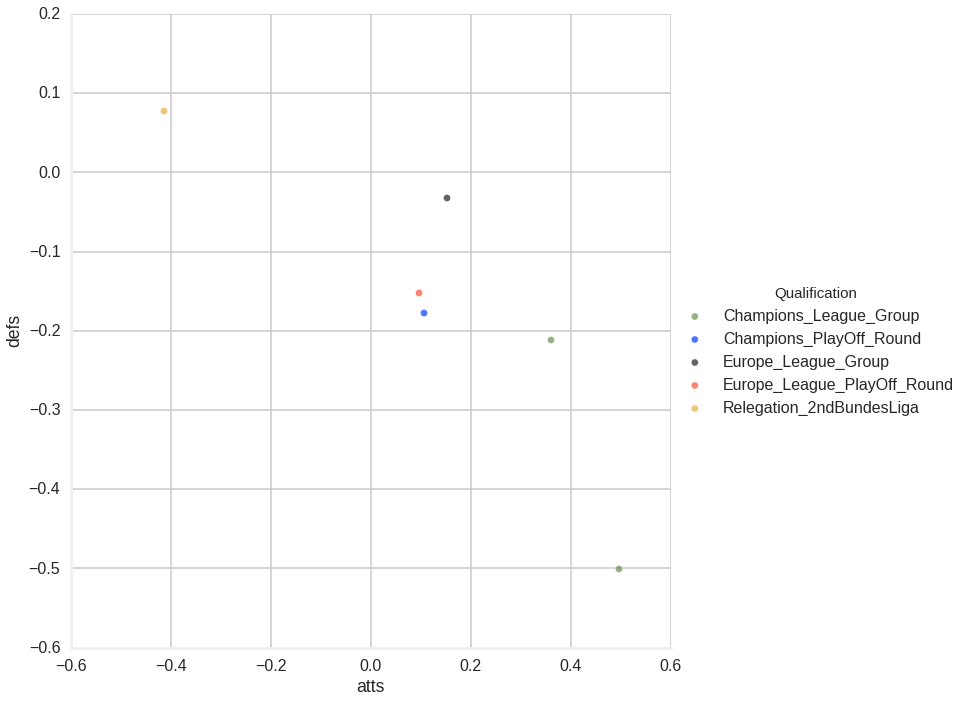

In [18]:
'''
    Plot posterior parameters of the teams selected from the final table.
'''
def _plot_final_table(self, prop1,prop2,selection,type_plot):    
    df_avg = pd.DataFrame({prop1: self.deterministic_stats[prop1]['mean'],
                           prop2: self.deterministic_stats[prop2]['mean'],
                          'teams':teams.team.values},                       
                      index=teams.team.values)
    df_avg = pd.merge(df_avg, self.table, left_index=True, right_on='Abbvr', how='left')
    
    def select_team(selections_crit):
        return np.array([ val in selections_crit for val in df_final_table['Qualification']])


    sns.set_context("poster")
    plt.figure(figsize=(15,8))

    g = sns.FacetGrid(df_avg.loc[select_team(selection)], hue=type_plot, size=10)
    g.map(plt.scatter, prop1, prop2, s=50, alpha=.7, linewidth=.5, edgecolor="white")
    g.add_legend();
    

# Update our Plotter
Plotter.plot_final_table = _plot_final_table



selection_criteria = ['Champions_League_Group',
    'Champions_PlayOff_Round',
    'Europe_League_Group',
    'Europe_League_PlayOff_Round',
    'Europe_League_PlayOff_3rdRound',
    'Relegation_PlayOff',
    'Relegation_2ndBundesLiga',
    'Relegation_2ndBundesLiga'
 ]
plotting = Plotter(bundesliga_model,df_final_table)
plotting.plot_final_table('atts','defs',selection_criteria,'Qualification')



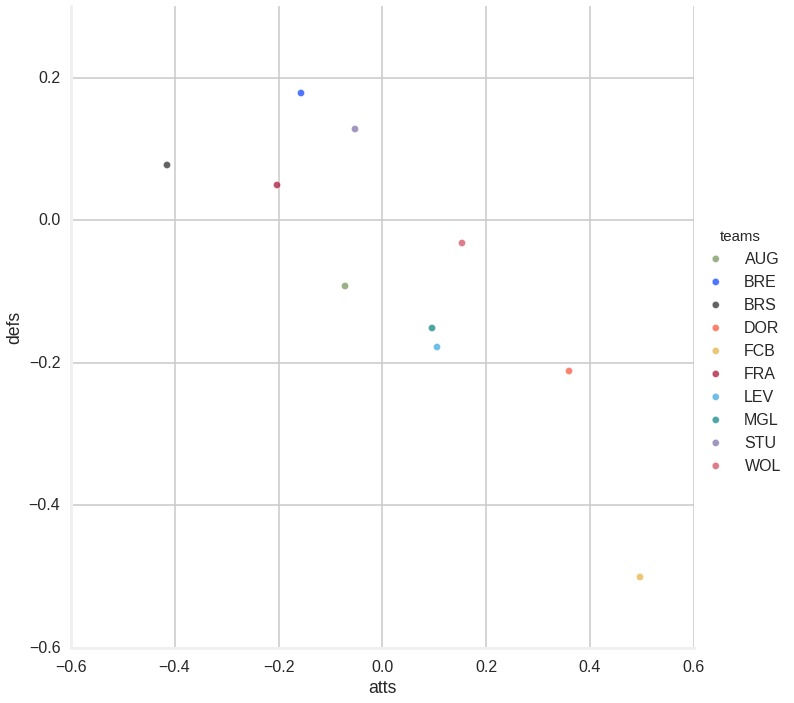

In [19]:
plotting.plot_final_table('atts','defs',selection_criteria,'teams')

So as you would expect, the top teams are in the lower right side of the chart, indicating a positive attack effect and a negative defense effect. Interestingly, FCB appears to have both a stronger attack and a stronger defense than two teams that finished above it in the table, DOR and LEV. But we're just looking at posterior means here, and we ought to take advantage of the fact that we can quantify our posterior uncertainty around these parameters. 
  
$$\\[5pt]$$
#### Plot of the HPDI

-------

Let's look at the Highest Posterior Density intervals (HPDI) for the attack parameters.

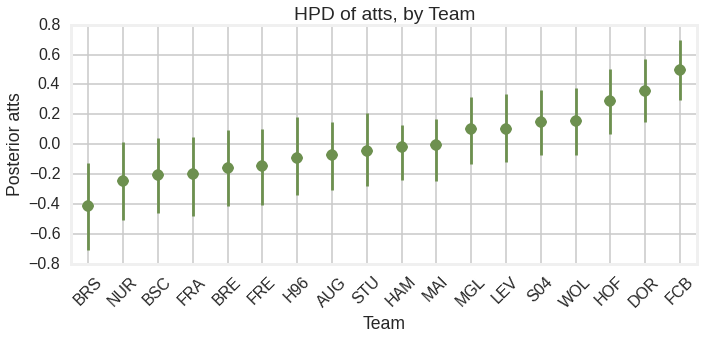

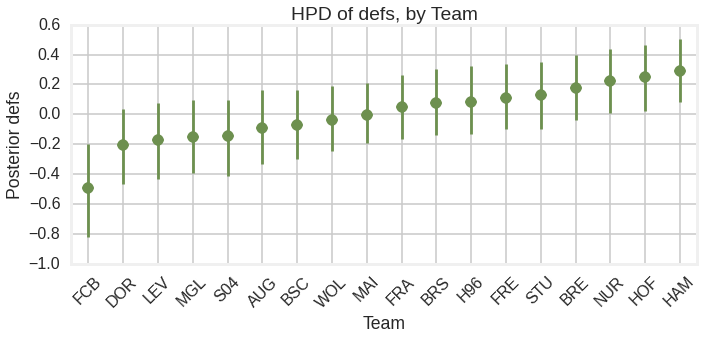

In [20]:
'''
    Plot posterior parameters of the teams selected from the final table.
'''
def _plot_HPDI(self, prop1):    
    #print deterministic_stats[prop1]['95% HPD interval'].T
    df_hpd = pd.DataFrame(self.deterministic_stats[prop1]['95% HPD interval'].T,
                          columns=['hpd_low', 'hpd_high'],    
                          index=teams.team.values)
    
    
    df_median = pd.DataFrame(self.deterministic_stats[prop1]['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
    df_hpd = df_hpd.join(df_median)
    
    
    df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
    df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
    df_hpd = df_hpd.sort_index(by='hpd_median')
    df_hpd = df_hpd.reset_index()
    df_hpd['x'] = df_hpd.index + .5
   
    sns.set_context("poster")
    fig, axs = plt.subplots(figsize=(10,4))    
    axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
    axs.set_title('HPD of %s, by Team'%prop1)
    axs.set_xlabel('Team')
    axs.set_ylabel('Posterior %s'%prop1)
    _= axs.set_xticks(df_hpd.index + .5)
    _= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

    
# Update our Plotter
Plotter.plot_HPDI = _plot_HPDI



plotting.plot_HPDI('atts')
plotting.plot_HPDI('defs')




$$\\[5pt]$$
Simulations
----------------------

-------


We can take draws from the posterior distributions of the parameters, and simulate a season or many seasons. Below is the simulation code, just so you can see how I did it.



In [21]:
'''
    Simulation support in the Model Class
'''

def _simulate_season(self,df=None):
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """

    # get the number of samples
    num_samples = self.traces['home'].shape[0]
    
    # randomly draw a seasson number from traces
    draw = np.random.randint(0, num_samples) 
    atts_draw = pd.DataFrame({'att': self.traces["atts"][draw, :],})
    defs_draw = pd.DataFrame({'def': self.traces["defs"][draw, :],})
    home_draw = self.traces["home"][draw]
    intercept_draw = self.traces["intercept"][draw]
    
    # make a season dataframe with new columns: att_home, def_home,att_away,def_away
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    
    # add random model paramers values generated for this season: home, intercept, home_theta etc
    
    season['home'] = home_draw # home parameter
    season['intercept'] = intercept_draw # intercept parameter
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)

    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                       x['att_away'] + 
                                                       x['def_home']), axis=1)    
    


    # the most interesting part: simulate the score of each match
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)

    # add dummy columns for categorical variables: each dummy will take 1 or 0
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))    
    
    return season


def _create_season_table(self,season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    """
    
    # get summary on home teams
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                        })
    # get summary on away teams
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })

    df = home.join(away)
    # how many 'x' were during the season for each command
    df['wins'] = df.home_wins + df.away_wins # x=wins
    df['draws'] = df.home_draws + df.away_draws # x=draws
    df['losses'] = df.home_losses + df.away_losses # x=losses
    df['points'] = df.wins * 3 + df.draws # total points collected
    df['gf'] = df.home_goals + df.away_goals # total goals scored
    df['ga'] = df.home_goals_against + df.away_goals_against # total goals missed
    df['gd'] = df.gf - df.ga # difference 
    
    df = pd.merge(teams, df, left_on='i', right_index=True) # add teams information
    df = df.sort_index(by='points', ascending=False) # sort teams by the points collected
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_CL'] = (df.position < 5).astype(int)
    df['relegated'] = (df.position > 17).astype(int)
    return df  

def _simulate_seasons(self,n=100,df=None):
    ''' simulates n seasons '''
    dfs = []
    for i in range(n):
        s = self.simulate_season(df)
        t = self.create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)


    
# Update our class with the sampling infrastructure.
Model.simulate_season = _simulate_season
Model.create_season_table = _create_season_table
Model.simulate_seasons = _simulate_seasons
seasons_simulated=bundesliga_model.simulate_seasons(100,df)

We extend our plotter to plot simulated points and scored goals for each team.

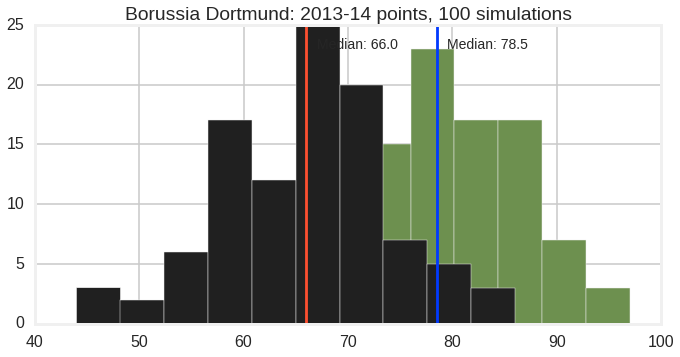

In [22]:
'''
    Plot simulated points for the team with Abbvr
'''
def _plot_sim_points(self, abbvr,seasons_simulated):    
    ''' plot the simulated points '''
    
     
    sns.set_context("poster")    
    ax = seasons_simulated.points[seasons_simulated.team == abbvr].hist(figsize=(10,5))
    median = seasons_simulated.points[seasons_simulated.team == abbvr].median()
    
    team_name = str(self.table.loc[self.table['Abbvr'] == abbvr,'Team'].values[0])
    num_sims= len(seasons_simulated)/self.model.traces['atts'].shape[1]
    ax.set_title('%s: 2013-14 points, %d simulations'%( team_name.decode('utf8'),num_sims))    
    ax.plot([median, median], ax.get_ylim())
    plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-2))

# Update our Plotter
Plotter.plot_sim_points = _plot_sim_points



# comparison DOR and FCB
plotting.plot_sim_points('FCB',seasons_simulated)
plotting.plot_sim_points('DOR',seasons_simulated)

    
    

And how many goals they scored:

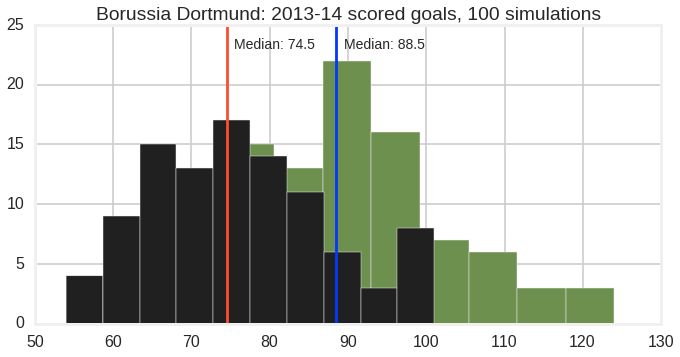

In [23]:
'''
    Plot simulated scored goals for the team with Abbvr
'''
def _plot_sim_scored_goals(self, abbvr,seasons_simulated):    
    ''' plot the simulated  scored goals  '''
    
     
    sns.set_context("poster")    
    ax = seasons_simulated.gf[seasons_simulated.team == abbvr].hist(figsize=(10,5))
    median = seasons_simulated.gf[seasons_simulated.team == abbvr].median()
    
    team_name = str(self.table.loc[self.table['Abbvr'] == abbvr,'Team'].values[0])    
    num_sims= len(seasons_simulated)/self.model.traces['atts'].shape[1]
    ax.set_title('%s: 2013-14 scored goals, %d simulations'%( team_name.decode('utf8'),num_sims))    
    ax.plot([median, median], ax.get_ylim())
    plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-2))

# Update our Plotter
Plotter.plot_sim_scored_goals = _plot_sim_scored_goals



# comparison DOR and FCB
plotting.plot_sim_scored_goals('FCB',seasons_simulated)
plotting.plot_sim_scored_goals('DOR',seasons_simulated)

    
    

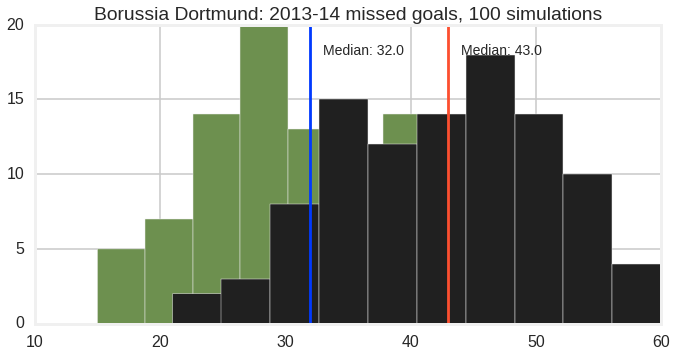

In [24]:
'''
    Plot simulated missed goals for the team with Abbvr
'''
def _plot_sim_missed_goals(self, abbvr,seasons_simulated):    
    ''' plot the simulated  missed goals  '''
    
     
    sns.set_context("poster")    
    ax = seasons_simulated.ga[seasons_simulated.team == abbvr].hist(figsize=(10,5))
    median = seasons_simulated.ga[seasons_simulated.team == abbvr].median()
    
    team_name = str(self.table.loc[self.table['Abbvr'] == abbvr,'Team'].values[0])    
    num_sims= len(seasons_simulated)/self.model.traces['atts'].shape[1]
    ax.set_title('%s: 2013-14 missed goals, %d simulations'%( team_name.decode('utf8'),num_sims))    
    ax.plot([median, median], ax.get_ylim())
    plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-2))

# Update our Plotter
Plotter.plot_sim_missed_goals = _plot_sim_missed_goals



# comparison DOR and FCB
plotting.plot_sim_missed_goals('FCB',seasons_simulated)
plotting.plot_sim_missed_goals('DOR',seasons_simulated)

    
    

We want to compare the simulated data with  a real table for 2013/2014 years from the Wikipedia [[4]](#Table).

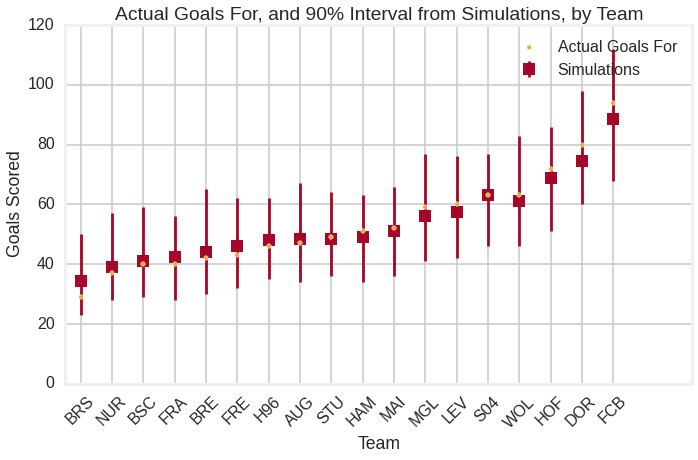

In [25]:
'''
    Plot final goals scored by each team 
'''
def _plot_goals(self, seasons_simulated):    
    ''' plot the simulated and real scored goals  '''
    
    g = seasons_simulated.groupby('team')
    season_hdis = pd.DataFrame({'points_lower': g.points.quantile(.05),
                            'points_upper': g.points.quantile(.95),
                            'goals_for_lower': g.gf.quantile(.05),
                            'goals_for_median': g.gf.median(),
                            'goals_for_upper': g.gf.quantile(.95),
                            'goals_against_lower': g.ga.quantile(.05),
                            'goals_against_upper': g.ga.quantile(.95),
                            })
    
    
    season_hdis = pd.merge(season_hdis, self.table, left_index=True, right_on='Abbvr')
    column_order = ['Abbvr', 'points_lower', 'Pts', 'points_upper', 
                'goals_for_lower', 'GF', 'goals_for_median', 'goals_for_upper',
                'goals_against_lower', 'GA', 'goals_against_upper',]
    season_hdis = season_hdis[column_order]
    season_hdis['relative_goals_upper'] = season_hdis.goals_for_upper - season_hdis.goals_for_median
    season_hdis['relative_goals_lower'] = season_hdis.goals_for_median - season_hdis.goals_for_lower
    season_hdis = season_hdis.sort_index(by='GF')
    season_hdis = season_hdis.reset_index()
    season_hdis['x'] = season_hdis.index + .5

    sns.set_context("poster")    
    fig, axs = plt.subplots(figsize=(10,6))
    axs.scatter(season_hdis.x, season_hdis.GF, c=sns.palettes.color_palette()[4], zorder = 10, label='Actual Goals For')
    axs.errorbar(season_hdis.x, season_hdis.goals_for_median, 
             yerr=(season_hdis[['relative_goals_lower', 'relative_goals_upper']].values).T, 
             fmt='s', c=sns.palettes.color_palette()[5], label='Simulations')
    axs.set_title('Actual Goals For, and 90% Interval from Simulations, by Team')
    axs.set_xlabel('Team')
    axs.set_ylabel('Goals Scored')
    axs.set_xlim(0, 20)
    axs.legend()
    _= axs.set_xticks(season_hdis.index + .5)
    _= axs.set_xticklabels(season_hdis['Abbvr'].values, rotation=45)
    
    
# Update our Plotter
Plotter.plot_goals = _plot_goals



# comparison 
plotting.plot_goals(seasons_simulated)

$$\\[5pt]$$
Predictions of  2014/2015 BundesLiga results
----------------------------------

------------------

Let's try to predict results on 2014/2015 season [[5]](#2015_Table). We compare simulated 1000 seasons and 
plot our predictions together with real results.
First, we generate 1000 seasons:


In [29]:
seasons_simulated_1000=bundesliga_model.simulate_seasons(1000,df)

Then, we scrappe the final table of BundesLiga results for the 2014/2015 season. 

In [30]:
# a page containing the data

wikipage='https://en.wikipedia.org/wiki/2014%E2%80%9315_Bundesliga#League_table'

# a pattern on the header to find the table among others
title_pattern='Pos<'

# a pattern on the class properties of the table used to find it 
table_props={"class" : "wikitable"}

# parse the table from the wiki page
wt=Wiki_Table(wikipage,table_props,title_pattern,"th")

#print wt.table
# create a dataframe on the data
table_csv=map(lambda x: ','.join(x),wt.table)
table_csv='\n'.join(table_csv)
data = StringIO(table_csv)

df_final_table_2015 = pd.read_csv(data,delimiter=',',header=None)

df_final_table_2015.columns = [
                 'Team', 'Pld','W','D','L','GF','GA','GD','Pts','Qualification'                
    ]
# fix some 'Qualification' values
df_final_table_2015.loc[0:2,'Qualification'] = 'Champions_League_Group'
df_final_table_2015.loc[3,'Qualification'] = 'Champions_PlayOff_Round'
df_final_table_2015.loc[4,'Qualification'] = 'Europe_League_Group'
df_final_table_2015.loc[5,'Qualification'] = 'Europe_League_PlayOff_Round'
df_final_table_2015.loc[6,'Qualification'] = 'Europe_League_PlayOff_3rdRound'
df_final_table_2015.loc[len(df_final_table_2015)-3,'Qualification'] = 'Relegation_PlayOff'
df_final_table_2015.loc[len(df_final_table_2015)-2,'Qualification'] = 'Relegation_2ndBundesLiga'
df_final_table_2015.loc[len(df_final_table_2015)-1,'Qualification'] = 'Relegation_2ndBundesLiga'


In [32]:
# add abbvreviations
df_final_table_2015['Abbvr'] = pd.Series(np.random.randn(), index=df_final_table.index)
def find_team(name):
    return np.array([ name in val for val in df_final_table_2015['Team']])

# the whole list of teams in the 2013-2014 season of the BundesLiga
df_final_table_2015.loc[find_team("Bayern Munich"),'Abbvr'] = "FCB" #1
df_final_table_2015.loc[find_team("Borussia Dortmund"),'Abbvr'] = "DOR" #2
df_final_table_2015.loc[find_team("Schalke 04"),'Abbvr'] = "S04" #3
df_final_table_2015.loc[find_team("Bayer Leverkusen"),'Abbvr'] = "LEV" #4
df_final_table_2015.loc[find_team("VfL Wolfsburg"),'Abbvr'] = "WOL" #5
df_final_table_2015.loc[find_team("nchengladbach"),'Abbvr'] = "MGL" #6
df_final_table_2015.loc[find_team("Mainz 05"),'Abbvr'] = "MAI" #7
df_final_table_2015.loc[find_team("FC Augsburg"),'Abbvr'] = "AUG" #8
df_final_table_2015.loc[find_team("1899 Hoffenheim"),'Abbvr'] = "HOF" #9
df_final_table_2015.loc[find_team("Hannover 96"),'Abbvr'] = "H96" #10
df_final_table_2015.loc[find_team("Hertha BSC"),'Abbvr'] = "BSC" #11
df_final_table_2015.loc[find_team("Werder Bremen"),'Abbvr'] = "BRE" #12
df_final_table_2015.loc[find_team("Eintracht Frankfurt"),'Abbvr'] = "FRA" #13
df_final_table_2015.loc[find_team("SC Freiburg"),'Abbvr'] = "FRE" #14
df_final_table_2015.loc[find_team("VfB Stuttgart"),'Abbvr'] = "STU" #15
df_final_table_2015.loc[find_team("Hamburger SV"),'Abbvr'] = "HAM" #16
df_final_table_2015.loc[find_team("rnberg"),'Abbvr'] = "NUR" #17
df_final_table_2015.loc[find_team("Eintracht Braunschweig"),'Abbvr'] = "BRS" #18



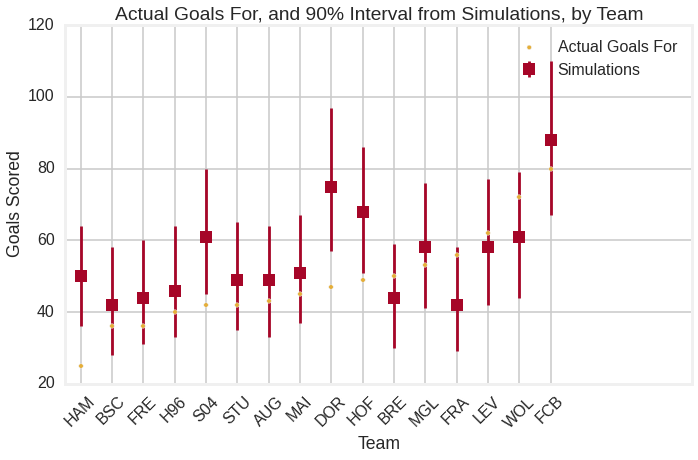

In [33]:
plotting.table=df_final_table_2015
plotting.plot_goals(seasons_simulated_1000)

Following, obtained results, we see that we have properly predicted (falled in the 90% HPDI of the simulated scored goals) the final results for such teams as 
>FCB,WOL,LEV,FRA,MGL etc

but also we have encountered some overestimations on scored goals for 
> DOR, HOF and HAM

Definitely, the main failer of the current season were  "Borussia Dortmund" (DOR) and 
"SF Hamburg" (HAM).


$$\\[5pt]$$
Prediction of the matches scoring in 2013/2014 season
----------------------

-------


It would be perhaps interesting to predict the scoring of the paticular matches.
We will add this functionality to the our model class. Here is a code.


In [34]:
'''
    Predict of the match result support in the Model Class
'''

def _predict_match_map(self,teams,team_abbvr_home,team_abbvr_away):    
    """
        makes predictions on the match using MAP  values
        :param: teams -- a table with the abbrevation and numerical code for each team
        :param: team_abbvr_home -- the abbrevation of the team playing at home
        :param: team_abbvr_away -- the abbrevation of the guest team        
    """
    
    #get indexes of the home/away teams
    i_home = teams.loc[teams['team']==team_abbvr_home,'i'].values[0]
    i_away = teams.loc[teams['team']==team_abbvr_away,'i'].values[0]

    
    # there are two ways of the calculation the score using MAP
    
    # method 1
    # get atts properties of all teams
    atts = bundesliga_model.map['atts'] 
        
    # get defs properties of all teams
    defs = bundesliga_model.map['defs']  
    
    # get home parameter
    home = bundesliga_model.map['home'] 
    
    # get intercept parameter
    intercept = bundesliga_model.map['intercept'] 
    
    
    #calculation of the scoring
    home_theta = np.exp(
            intercept+
            home+
            atts[i_home]+
            defs[i_away]
        )

    away_theta = np.exp(
            intercept+            
            atts[i_away]+
            defs[i_home]
        )

    # method 2
    # get  home_theta and  away_theta
    #i_theta = i_home*(len(teams)-1) + i_away -1     
    #home_theta = bundesliga_model.map['home_theta'][i_theta]
    #away_theta = bundesliga_model.map['away_theta'][i_theta]
    
    
    home_goals = np.random.poisson(home_theta)
    away_goals = np.random.poisson(away_theta)
        
    
    return (home_goals,away_goals,"win" if home_goals>away_goals else ("loss" if away_goals!=home_goals else "draw"))



def _predict_match_mcmc(self,teams,team_abbvr_home,team_abbvr_away):    
    """
        makes predictions on the match using MCMC simulations
        :param: teams -- a table with the abbrevation and numerical code for each team
        :param: team_abbvr_home -- the abbrevation of the team playing at home
        :param: team_abbvr_away -- the abbrevation of the guest team        
    """

    #get indexes of the home/away teams
    i_home = teams.loc[teams['team']==team_abbvr_home,'i'].values[0]
    i_away = teams.loc[teams['team']==team_abbvr_away,'i'].values[0]
    
    # get the number of samples
    num_samples = self.traces['home'].shape[0]
    
    # randomly draw a seasson number from traces
    draw = np.random.randint(0, num_samples) 
    atts_draw = self.traces["atts"][draw, :]
    defs_draw = self.traces["defs"][draw, :]
    home_draw = self.traces["home"][draw]
    intercept_draw = self.traces["intercept"][draw]


     #calculation of the scoring
    home_theta = np.exp(
            intercept_draw+
            home_draw+
            atts_draw[i_home]+
            defs_draw[i_away]
        )

    away_theta = np.exp(
            intercept_draw+            
            atts_draw[i_away]+
            defs_draw[i_home]
        )


     
    home_goals = np.random.poisson(home_theta)
    away_goals = np.random.poisson(away_theta)
        
    
    return (home_goals,away_goals,"win" if home_goals>away_goals else ("loss" if away_goals!=home_goals else "draw"))




# Update the model definition
Model.predict_match_map = _predict_match_map
Model.predict_match_mcmc = _predict_match_mcmc

print bundesliga_model.predict_match_map(teams,"AUG","LEV")
print bundesliga_model.predict_match_mcmc(teams,"AUG","LEV")


(2, 0, 'win')
(1, 1, 'draw')


Let's extend our plotter to make plots of our score-predictions.

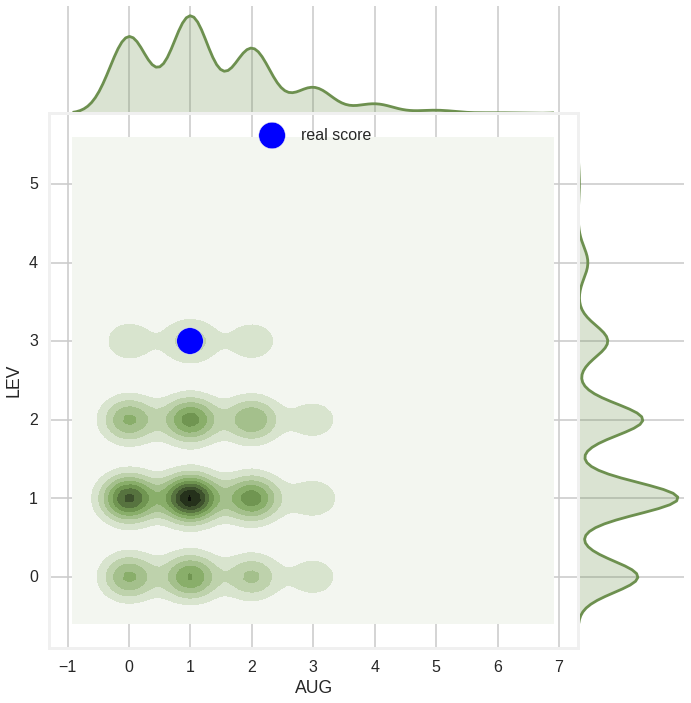

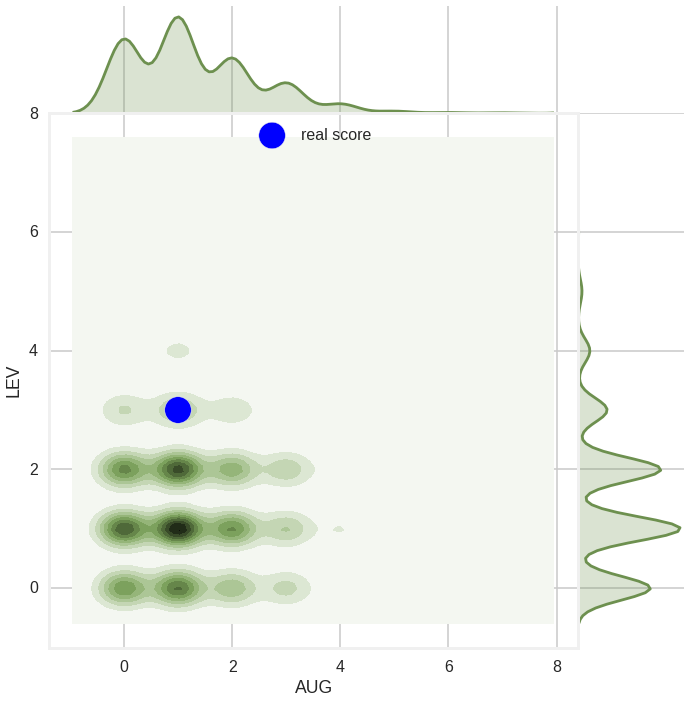

In [35]:
'''
    Plot predicted scores for the team with team_abbvr_home,team_abbvr_away
'''
def _plot_predicted_score(self, model,teams ,team_abbvr_home,team_abbvr_away,n,real_score_data=None,type_of_predict='MAP'):    
    ''' plot the predicted scores '''
    
    
    sns.set_context("poster")
    plt.figure(figsize=(15,8))
    func = model.predict_match_map
    if type_of_predict == "MCMC": func = model.predict_match_mcmc
        
    #f, axes = pl.subplots(figsize=(12, 8))
    

    x = pd.Series(np.array([ func(teams,team_abbvr_home,team_abbvr_away)[0] for i in range(n) ]), name=team_abbvr_home)
    y = pd.Series(np.array([ func(teams,team_abbvr_home,team_abbvr_away)[1] for i in range(n) ]), name=team_abbvr_away)
    
    # Show the joint distribution using kernel density estimation
    g = sns.jointplot(x, y, kind="kde", size=10,space=0)            
    
    if real_score_data is not None:    
        ax = plt.gcf().axes[0]
        real_x=real_score_data.loc[(real_score_data['home'] == team_abbvr_home) & (real_score_data['away'] == team_abbvr_away), "home_score"]
        real_y=real_score_data.loc[(real_score_data['home'] == team_abbvr_home) & (real_score_data['away'] == team_abbvr_away), "away_score"]                        
        ax.scatter(real_x.values,real_y.values ,s=np.array([np.pi * (15)**2]),label='real score')
        _ = ax.legend(loc='upper center', shadow=True)
        
  
    return


# Update our Plotter
Plotter.plot_predicted_score = _plot_predicted_score
    
plotting.plot_predicted_score(bundesliga_model,teams,"AUG","LEV",1000,df,'MAP')
plotting.plot_predicted_score(bundesliga_model,teams,"AUG","LEV",1000,df,'MCMC')    

>It looks like the score of AUG/LEV as 1:3 was clearly strange. We expected a result 1:1.
        

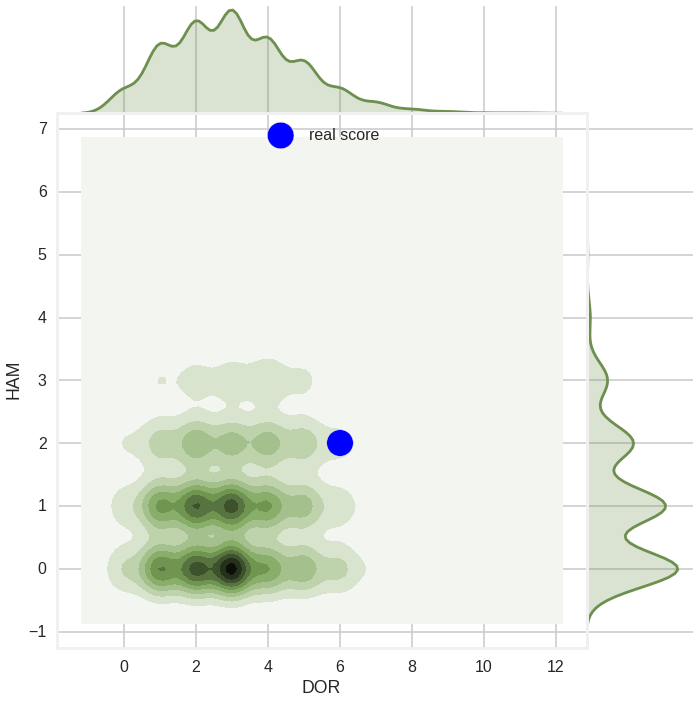

In [36]:
plotting.plot_predicted_score(bundesliga_model,teams,"DOR","HAM",1000,df,'MAP')

And again,we expected results 2:1, 3:0,3:1,4:1 but not 6:2.

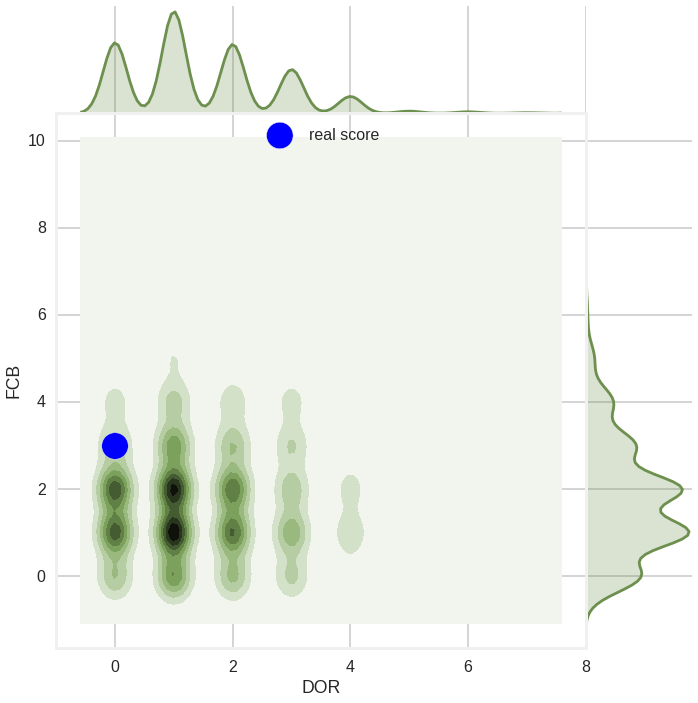

In [37]:
plotting.plot_predicted_score(bundesliga_model,teams,"DOR","FCB",1000,df,'MAP')

Here we add some statistical calculation on mean, median and HPDI of the predicted scoring to our model.

In [39]:
'''
   statistics on predicted scores
'''

def _pediction_scrore_statistics(self,teams ,team_abbvr_home,team_abbvr_away,n,CL=0.05):
    """ make a table on statistics """
    
    
    #get indexes of the home/away teams
    i_home = teams.loc[teams['team']==team_abbvr_home,'i'].values[0]
    i_away = teams.loc[teams['team']==team_abbvr_away,'i'].values[0]
    
    home_scores=[]
    away_scores=[]
    for i in range(n):
        home_score,away_score,_ = self.predict_match_map(teams,team_abbvr_home,team_abbvr_away)
        home_scores+=[home_score]
        away_scores+=[away_score]

    stats= pd.DataFrame({
             'home_score':  home_scores,
             'away_score':  away_scores,        
            }).describe(percentiles=[.05,.1,.25,.32,.31,.5,.68,.69,.75,.90,.95])
    min_val=str(int((1.-CL)*100))+'%'    
    max_val=str(int((CL)*100))+'%'
    
    stats= pd.DataFrame.from_records(
            [
                (team_abbvr_home,stats["home_score"]["mean"],stats["home_score"][min_val],stats["home_score"][max_val]),
                (team_abbvr_away,stats["away_score"]["mean"],stats["away_score"][min_val],stats["away_score"][max_val])
             ]
        )
    stats.columns = [
                 'Team', 'Mean',min_val,max_val              
    ]
    return stats


# Update the model definition
Model.pediction_scrore_statistics = _pediction_scrore_statistics

bundesliga_model.pediction_scrore_statistics(teams,"AUG","LEV",1000,CL=0.95)


,Team,Mean,5%,95%
0,AUG,1.280,0,3.00
1,LEV,1.329,0,3.05


For example, from the table above, we could expect at least one goal should be scored. 
Also the case when more than 2 goals scored by one team, is unexpected. We can introduce
an ad-hoc calculation of the particular result:

In [40]:
'''
   probability on predicted scores
'''

def _pediction_scrore_probas(self,teams ,team_abbvr_home,team_abbvr_away,n):
    """ calculate probas a table on statistics """
    
    
    #get indexes of the home/away teams
    i_home = teams.loc[teams['team']==team_abbvr_home,'i'].values[0]
    i_away = teams.loc[teams['team']==team_abbvr_away,'i'].values[0]
    
    scores={}
    for i in range(n):        
        home_score,away_score,_ = self.predict_match_map(teams,team_abbvr_home,team_abbvr_away)
        if (home_score,away_score) in scores.keys():
            scores[(home_score,away_score)]+=1.
        else:
            scores[(home_score,away_score)]=1.
    
    # change values to probabilites
    for key in  scores.keys():
        scores[key]*=100./float(n)

    import operator
    return scores,sorted(scores.items(), key=operator.itemgetter(1),reverse=True)

        

# Update the model definition
Model.pediction_scrore_probas = _pediction_scrore_probas

# get first five results with the highest probabilities
print bundesliga_model.pediction_scrore_probas(teams,"AUG","LEV",1000)[1][:5]  

# what is the probability to get result 4:1
try:
    proba = bundesliga_model.pediction_scrore_probas(teams,"AUG","LEV",1000)[0][(4,1)]
except:
    proba =0.
print proba

[((1, 1), 14.0), ((0, 1), 9.3), ((1, 0), 8.5), ((2, 0), 7.800000000000001), ((2, 1), 7.7)]
1.1


So, following our model, we see that the score 1:1 has a frequency  probability about 14%
while, 4:1 has 1.1% correspondingly.

$$\\[5pt]$$
Prediction of the matches scoring for 2015/2016 season
----------------------

-------

As a final task, I would like to predict the table like this [[2](#Results)] for the
2015/2016 season of the BundesLiga. First, we scrape data of 2013/2014 and 2014/2015, then we combine them and train our model. Finally, we will predict results of the matches
between teams in each pair.

The fist step is scrapping.



In [41]:
# 2013/2014
# a page containing the data
wikipage='https://en.wikipedia.org/wiki/2013%E2%80%9314_Bundesliga#Results'

# a pattern on the header to find the table among others
title_pattern='Home ╲ Away'

# a pattern on the class properties of the table used to find it 
table_props={"class" : "wikitable"}

# parse the table from the wiki page
wt=Wiki_Table(wikipage,table_props,title_pattern)

# create a dataframe on the data
table_csv=map(lambda x: ','.join(x),wt.table)
table_csv='\n'.join(table_csv)
data = StringIO(table_csv)


df_2013 = pd.read_csv(data,delimiter=',',index_col=0)
df_2013.index = df_2013.columns
rows = []
for i in df_2013.index:
    for c in df_2013.columns:
        if i == c: continue
        score = df_2013.ix[i, c]
        score = [int(row) for row in score.split('-')]        
        rows.append([i, c, score[0], score[1]])
df_2013 = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score'])




In [42]:
# 2014/2015

# a page containing the data
wikipage='https://en.wikipedia.org/wiki/2014%E2%80%9315_Bundesliga#Results'

# a pattern on the header to find the table among others
title_pattern='Home ╲ Away'

# a pattern on the class properties of the table used to find it 
table_props={"class" : "wikitable"}

# parse the table from the wiki page
wt=Wiki_Table(wikipage,table_props,title_pattern)

# create a dataframe on the data
table_csv=map(lambda x: ','.join(x),wt.table)
table_csv='\n'.join(table_csv)
data = StringIO(table_csv)


df_2014 = pd.read_csv(data,delimiter=',',index_col=0)
df_2014.index = df_2014.columns
rows = []
for i in df_2014.index:
    for c in df_2014.columns:
        if i == c: continue
        score = df_2014.ix[i, c]
        score = [int(row) for row in score.split('-')]        
        rows.append([i, c, score[0], score[1]])
df_2014 = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score'])


In [43]:
print df_2013.describe()
print df_2014.describe()

       home_score  away_score
count  306.000000  306.000000
mean     1.748366    1.411765
std      1.383301    1.257264
min      0.000000    0.000000
25%      1.000000    0.000000
50%      2.000000    1.000000
75%      3.000000    2.000000
max      6.000000    7.000000
       home_score  away_score
count  306.000000  306.000000
mean     1.588235    1.166667
std      1.320851    1.190812
min      0.000000    0.000000
25%      1.000000    0.000000
50%      1.000000    1.000000
75%      2.000000    2.000000
max      8.000000    6.000000


In [44]:
# combine the results of 2013/2014 and 2014/2015 seasons
df_2013_2014=pd.concat([df_2013,df_2014], ignore_index=True)
df_2013_2014.describe()

,home_score,away_score
count,612.000000,612.000000
mean,1.668301,1.289216
std,1.353703,1.229619
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,2.250000,2.000000
max,8.000000,7.000000


Extract the list of teams participating in both seasons:

In [45]:
teams_2013_2014 = df_2013_2014.home.unique()
teams_2013_2014 = pd.DataFrame(teams_2013_2014, columns=['team'])
teams_2013_2014['i'] = teams_2013_2014.index
print "Number of teams: {0}".format(len(teams_2013_2014))
teams_2013_2014.head()

Number of teams: 20


,team,i
0,AUG,0
1,LEV,1
2,FCB,2
3,DOR,3
4,MGL,4


Merge the `teams` info in our dataframe:

In [46]:
df_2013_2014 = pd.merge(df_2013_2014, teams_2013_2014, left_on='home', right_on='team', how='left')
df_2013_2014 = df_2013_2014.rename(columns = {'i': 'i_home'}).drop('team', 1)
df_2013_2014 = pd.merge(df_2013_2014, teams_2013_2014, left_on='away', right_on='team', how='left')
df_2013_2014 = df_2013_2014.rename(columns = {'i': 'i_away'}).drop('team', 1)
print "How many games in both seasons are? : %d "%len(df_2013_2014)
df_2013_2014.head()

How many games in both seasons are? : 612 


,home,away,home_score,away_score,i_home,i_away
0,AUG,LEV,1,3,0,1
1,AUG,FCB,1,0,0,2
2,AUG,DOR,0,4,0,3
3,AUG,MGL,2,2,0,4
4,AUG,BRS,4,1,0,5


In [47]:
observed_home_goals_2013_2014 = df_2013_2014.home_score.values
observed_away_goals_2013_2014 = df_2013_2014.away_score.values
home_team_2013_2014 = df_2013_2014.i_home.values
away_team_2013_2014 = df_2013_2014.i_away.values
num_teams_2013_2014 = len(df_2013_2014.i_home.unique())
num_games_2013_2014 = len(home_team_2013_2014)

print "Number of games: {0}".format(num_games_2013_2014)


# prepare the starting point for our model
g = df_2013_2014.groupby(['i_away'])
att_starting_points = np.log(g.away_score.mean())
g = df_2013_2014.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean()) # negative because this property plays


Number of games: 612


Let's build our model:

In [48]:
# create the model object used in the further analysis
observed_data_model_2013_2014 = {
                'observed_home_goals':observed_home_goals_2013_2014,
                'observed_away_goals':observed_away_goals_2013_2014,
                'num_teams':num_teams_2013_2014,
                'home_team':home_team_2013_2014,
                'away_team':away_team_2013_2014,
            }
bundesliga_model_2013_2014 = Model(observed_data_model_2013_2014)
? bundesliga_model_2013_2014   

INFO:root:building the  model....
INFO:root:done building the  model


Calculate MAP:

In [659]:
# remove data/map folder first
#!rm -r "data/map"

In [50]:
logging.info('MAP of  %s is %2.4f'%('tau_att',bundesliga_model_2013_2014.map['tau_att']))
print 'saving...'
#save_np_vars(bundesliga_model_2013_2014.map,bundesliga_model_2013_2014.map_dir)

INFO:root:MAP of  tau_att is 15.2102


saving...


Draw MCMC:    

In [51]:
# let's make samples
bundesliga_model_2013_2014.draw_samples(30000)

INFO:root:drawing 30000 samples
INFO:root:backing up trace to directory: data/mcmc


 [-----------------100%-----------------] 30000 of 30000 complete in 44.8 sec

Make simulation of 100 seasons:

In [52]:
seasons_simulated_2013_2014=bundesliga_model_2013_2014.simulate_seasons(100,df_2013_2014)

Plot final goals of the teams:

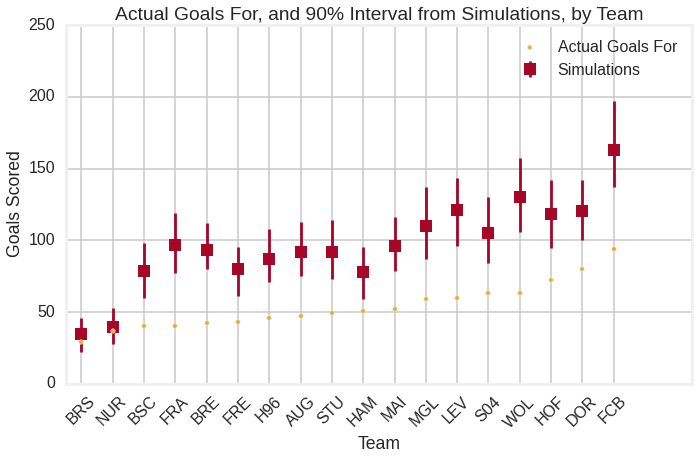

In [53]:
plotting_2015 = Plotter(bundesliga_model_2013_2014,df_final_table) # df_final_table is not correct
plotting_2015.plot_goals(seasons_simulated_2013_2014) # because the df_final_table is not correct
# "Actual Goals" are not correct

Finally, we can predict the table as in at wikipage of scores for teams played in the season 2013/2014. The scores with the highest probabilities are chosen.

In [54]:
rows_2015 = []
for x in df_2013.values:   
    score=bundesliga_model_2013_2014.pediction_scrore_probas(teams_2013_2014,x[0],x[1],500)[1][1]
    rows_2015.append((x[0],x[1],score[0][0],score[0][1]))

In [55]:
df_2015 = pd.DataFrame(rows_2015, columns =  df_2013.columns.values)
df_2015.head(len(df_2015))

,home,away,home_score,away_score
0,AUG,LEV,0,1
1,AUG,FCB,1,2
2,AUG,DOR,1,2
3,AUG,MGL,2,1
4,AUG,BRS,2,0
5,AUG,FRA,1,1
6,AUG,FRE,1,0
7,AUG,HAM,2,1
8,AUG,H96,2,1
9,AUG,BSC,1,1



$$\\[5pt]$$
References
----------------------

-------


<a id='Blog'></a>
[[1]http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/]( http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/)

<a id='Results'></a>
[[2] 2013/14 BundesLiga results]( https://en.wikipedia.org/wiki/2013%E2%80%9314_Bundesliga#Results)

<a id='Scrapper'></a>
[[3] a Wiki Scrapper](https://adesquared.wordpress.com/2013/06/16/using-python-beautifulsoup-to-scrape-a-wikipedia-table/)


<a id='Table'></a>
[[4] 2013/14 BundesLiga  table]( https://en.wikipedia.org/wiki/2013%E2%80%9314_Bundesliga#League_table)

<a id='2015_Table'></a>
[[5] 2014/15 BundesLiga  table]( https://en.wikipedia.org/wiki/2014%E2%80%9315_Bundesliga#League_table)


